### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

# Business case

A healthcare provider is looking to track which patients are likely to be readmitted based on historical data, so that they can anticipate their patient's needs and provide them the appropriate care.

Patients who have been hospitalized are getting their vitals monitored periodically, and this data is added to a dataset. When each of the patient's vitals have been recorded, the recorded measurements populate a new row in a dataset, along with the patient's age, gender, name, place of residence, diagnosed condition, the date of the onset of the condition, the date of the recorded measurement, and the time since the patient has been discharged from the hospital.

For many patients, their status as patients who have been readmitted to the hospital within 30 days of discharge has been recorded. This is the historical data that the healthcare provider can used to make informed decisions about patients whose status as 30-day-readmitted patients is still to be determined.

# Import packages

In [64]:
import pandas as pd
import oci
import time
import os
from datetime import datetime
from os.path import exists
from sklearn.metrics import get_scorer
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.dataset.factory import DatasetFactory
## USE ADS for model building
import ads
import logging
import seaborn as sns
from ads.evaluations.evaluator import ADSEvaluator
from ads.model.framework.automl_model import AutoMLModel
from ads.common.auth import default_signer
from oci.object_storage import ObjectStorageClient
from datetime import date
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.model.deployment import ModelDeployer, ModelDeploymentProperties
from ads.common.model import ADSModel
from ads.catalog.model import ModelCatalog
import tempfile

# Setup configuration for connecting to OCI Object Storage

In [3]:
# Setup basic variables
# Auth Config
config = oci.config.from_file('~/.oci/config')

# Read training data from OCI Object store buckets

In [75]:
## Read training data from OCI Object store buckets using API keys

ads.set_auth(auth="api_key", oci_config_location="~/.oci/config", profile="DEFAULT")

conn_os = {
    "bucket_name": "<bucket_name>"",
    "namespace": "<tenancy_namespace>",
    "file_name": "Train-Data-v2.csv"
    }

train_ds = pd.read_csv(f"oci://{conn_os['bucket_name']}@{conn_os['namespace']}/{conn_os['file_name']}", storage_options=default_signer())

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

SyntaxError: EOL while scanning string literal (<ipython-input-75-70034b00ac5f>, line 6)

In [77]:
train_ds

,Unnamed: 0,PATIENT_NUM,FULL_NAME,BIRTH_DT,AGE,GENDER_NAME,HOME_CITY,HOME_POSTAL_CODE,HOME_STATE_CODE,PATIENT_GROUP_NAME,DIAGNOSIS_CODE,DIAGNOSIS_NAME,ONSET_DT,OBSV_RECORDED_DT,READMISSION_FLG,OBSERVATION_NAME,OBSERVATION_CODE,OBSV_VALUE_NUMERIC,DAYS_SINCE_DIAG,WEEKS_SINCE_DIAG,MONTHS_SINCE_DIAG
0,0,9999000003,Sam C Jefferson I,12/31/32,86,Male,NaN,NaN,NaN,READMISSION,I21.09,AMI - Anterior Wall Other Coronary Artery (I21.09),11/21/18,12/22/18,Y,Pulse,C0232117,80.0,24,3,1
1,1,9999000003,Sam C Jefferson I,12/31/32,86,Male,NaN,NaN,NaN,READMISSION,I21.09,AMI - Anterior Wall Other Coronary Artery (I21.09),11/21/18,12/25/18,Y,Pulse,C0232117,78.0,27,4,1
2,2,9999000003,Sam C Jefferson I,12/31/32,86,Male,NaN,NaN,NaN,READMISSION,I21.09,AMI - Anterior Wall Other Coronary Artery (I21.09),11/21/18,1/19/16,Y,Diastolic BP,C0428883,105.0,-1044,-149,-34
3,3,9999000003,Sam C Jefferson I,12/31/32,86,Male,NaN,NaN,NaN,READMISSION,I21.09,AMI - Anterior Wall Other Coronary Artery (I21.09),11/21/18,12/14/18,Y,Peripheral Oxygen Saturation,C2317096,91.0,16,2,1
4,4,9999000003,Sam C Jefferson I,12/31/32,86,Male,NaN,NaN,NaN,READMISSION,I21.09,AMI - Anterior Wall Other Coronary Artery (I21.09),11/21/18,12/14/18,Y,Peripheral Oxygen Saturation,C2317096,93.0,16,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999994,999994,56887,Arletta S HUDSON,9/16/39,82,Female,NaN,NaN,NaN,READMISSION,I21.4,AMI - Non-ST elevation,11/22/18,1/16/16,N,Pulse,C0232117,68.0,-1048,-150,-34
999995,999995,57312,Loma H MEZA,11/27/77,44,Female,NaN,NaN,NaN,READMISSION,I21.09,AMI - Anterior Wall Other Coronary Artery (I21.09),11/21/18,1/13/16,N,Pulse,C0232117,74.0,-1050,-150,-34
999996,999996,57002,Merritt S LAMBERT,7/5/76,45,Male,NaN,NaN,NaN,READMISSION,I21.09,AMI - Anterior Wall Other Coronary Artery (I21.09),11/20/18,12/20/18,N,Diastolic BP,C0428883,72.0,23,3,1
999997,999997,56807,Tabitha J AGUILAR,9/14/43,78,Male,NaN,NaN,NaN,READMISSION,I21.01,AMI - Left Main Coronary Artery (I21.01),11/20/18,12/15/18,Y,Systolic BP,C0871470,126.0,18,3,1


# Data Processing 

In [78]:
## Data Processing

age_df = train_ds[['PATIENT_NUM','AGE','GENDER_NAME']].drop_duplicates()
tmp = train_ds.groupby(['PATIENT_NUM','OBSERVATION_CODE']).agg({'OBSV_VALUE_NUMERIC': ['min','max', 'mean','std']})
tmp1 = tmp.reset_index()
tmp1.columns=['PATIENT_NUM','OBSERVATION_CODE','OBS_MIN','OBS_MAX','OBS_MEAN','OBS_std']

# Pivot to get one row for each patient 
tmp2=pd.pivot_table(tmp1,columns=['OBSERVATION_CODE'],index=['PATIENT_NUM'],values=['OBS_MIN','OBS_MAX','OBS_MEAN','OBS_std'])
tmp2.columns = [col[0]+"_"+col[1] for col in tmp2.columns]
tmp3 = tmp2.reset_index()
tmp4= tmp3[[col for col in tmp3.columns if not 'READ' in col]]
target_df=train_ds[['PATIENT_NUM','READMISSION_FLG']].drop_duplicates()
final_df1 = target_df.merge(age_df, how='inner', on='PATIENT_NUM')
final_df2 = final_df1.merge(tmp4, how='inner',on = 'PATIENT_NUM')
final_df3 = final_df2.fillna(0)
final_df4 = final_df3.drop(columns=['PATIENT_NUM'])
final_train_ds = DatasetFactory.from_dataframe(final_df4,target="READMISSION_FLG")

loop1:   0%|          | 0/4 [00:00<?, ?it/s]

# Feature Engineering using Oracle ADS 

In [79]:
ds_engineered = final_train_ds.auto_transform(fix_imbalance=False)

loop1:   0%|          | 0/7 [00:00<?, ?it/s]

# Exploratory Data Analysis

In [11]:
final_train_ds.show_in_notebook()

Accordion(children=(HTML(value='<h1>Name: User Provided DataFrame</h1><h3>Type: BinaryClassificationDataset</h…

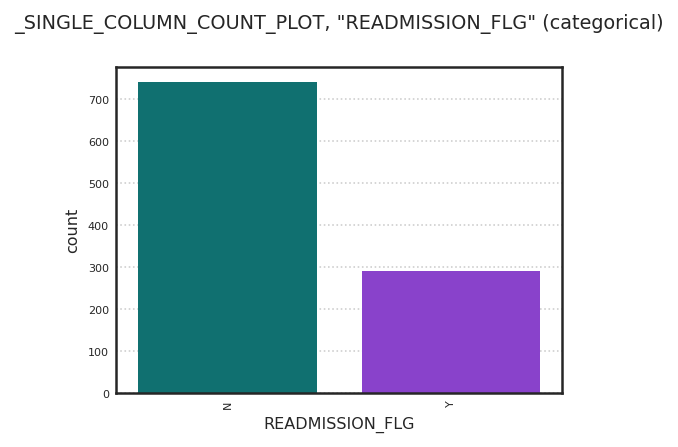

In [21]:
final_train_ds.target.show_in_notebook()

# Automatic Data Visualization

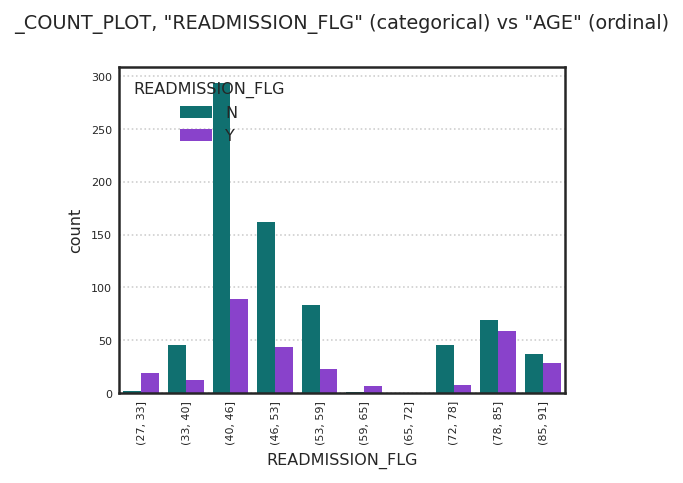

In [22]:
final_train_ds.plot('READMISSION_FLG', y='AGE').show_in_notebook()

# Model Training using Oracle AutoML

In [80]:
## Train model using Oracle Accelerated Data Science AutoML

ml_engine = OracleAutoMLProvider()
#train, test = final_train_ds.train_test_split(test_size=0.2)
train, test = ds_engineered.train_test_split(test_size=0.2)
oracle_automl = AutoML(train, provider=ml_engine)
automl_model1, baseline1 = oracle_automl.train() # alglrithm selection is done here

INFO:xengine:All work stopped
INFO:xengine:All work stopped
INFO:xengine:All work stopped
INFO:xengine:All work stopped


Training Dataset size,"(824, 23)"
Validation Dataset size,None
CV,5
Target variable,READMISSION_FLG
Optimization Metric,neg_log_loss
Initial number of Features,23
Selected number of Features,4
Selected Features,"Index(['OBS_MAX_ACT_WLK_STP_CNT', 'OBS_MAX_C0005910', 'OBS_MEAN_C0428883', 'OBS_MEAN_MED_ADHERENCE'], dtype='object')"
Selected Algorithm,ExtraTreesClassifier
End-to-end Elapsed Time (seconds),39.8778
Selected Hyperparameters,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max_features': 0.777777778, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 0.000625, 'min_samples_split': 0.00125, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 16, 'oob_score': False, 'random_state': 7, 'verbose': 0, 'warm_start': False}"


Rank based on Performance,Algorithm,#Samples,#Features,Mean Validation Score,Hyperparameters,CPU Time,Memory Usage
2,ExtraTreesClassifier_MIClassification_FS,824,4,-0.0296,"{'n_estimators': 100, 'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 0.777777778, 'min_samples_leaf': 0.000625, 'min_samples_split': 0.00125}",1.9225,0.0000
3,ExtraTreesClassifier_HT,824,4,-0.0300,"{'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 0.7777852780000001, 'min_samples_leaf': 0.000625, 'min_samples_split': 0.00125, 'n_estimators': 100}",1.5492,0.0000
4,ExtraTreesClassifier_HT,824,4,-0.0300,"{'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 0.777777778, 'min_samples_leaf': 0.000625, 'min_samples_split': 0.00125, 'n_estimators': 100}",1.5931,0.0000
5,ExtraTreesClassifier_HT,824,4,-0.0300,"{'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 0.777777778, 'min_samples_leaf': 0.000625, 'min_samples_split': 0.00125, 'n_estimators': 101}",1.3829,0.0000
6,ExtraTreesClassifier_HT,824,4,-0.0300,"{'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 0.777777778, 'min_samples_leaf': 0.000625, 'min_samples_split': 0.00125, 'n_estimators': 101}",1.4109,0.0000
...,...,...,...,...,...,...,...
124,ExtraTreesClassifier_ANOVAF_FS,824,2,-0.6029,"{'n_estimators': 100, 'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 0.777777778, 'min_samples_leaf': 0.000625, 'min_samples_split': 0.00125}",1.8366,0.0000
125,DecisionTreeClassifier_AS,824,24,-1.5095,"{'class_weight': None, 'max_features': 1.0, 'min_samples_leaf': 0.000625, 'min_samples_split': 0.00125}",0.1147,0.0003
126,GaussianNB_AS,824,24,-1.6883,{},0.1163,0.0008
127,ExtraTreesClassifier_ANOVAF_FS,824,1,-2.2881,"{'n_estimators': 100, 'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 0.777777778, 'min_samples_leaf': 0.000625, 'min_samples_split': 0.00125}",1.7051,0.0000


# Model Explaination

Feature Importance Explanations


In [73]:
explainer = ADSExplainer(train, automl_model1)
global_explainer = explainer.global_explanation()
global_explainer.show_in_notebook()

loop1:   0%|          | 0/3 [00:00<?, ?it/s]

MLXProgBar:   0%|          | 0/20 [00:00<?, ?it/s]

MLXProgBar:   0%|          | 0/3 [00:00<?, ?it/s]

One or more features (["FEATURE NAMES: ['AGE', 'GENDER_NAME', 'OBS_MAX_2571-8', 'OBS_MAX_ACT_WLK_STP_CNT', 'OBS_MAX_C0005910', 'OBS_MAX_C0232117', 'OBS_MAX_C0428883', 'OBS_MAX_MED_ADHERENCE', 'OBS_MEAN_2571-8', 'OBS_MEAN_ACT_WLK_STP_CNT', 'OBS_MEAN_C0005910', 'OBS_MEAN_C0232117', 'OBS_MEAN_C0428883', 'OBS_MEAN_C2317096', 'OBS_MEAN_MED_ADHERENCE', 'OBS_MIN_C0428883', 'OBS_MIN_MED_ADHERENCE', 'OBS_STD_2571-8', 'OBS_STD_ACT_WLK_STP_CNT', 'OBS_STD_C0232117', 'OBS_STD_C0428883', 'OBS_STD_C2317096', 'OBS_STD_MED_ADHERENCE']\nEXPLANATIONS: \n\t\t[0] OBS_MEAN_MED_ADHERENCE: ATTRIBUTION:0.20307606768495606, STANDARD DEVIATION:0.007738950799142795\n\t\t[1] OBS_MAX_ACT_WLK_STP_CNT: ATTRIBUTION:0.17319791884523772, STANDARD DEVIATION:0.008956005207894887\n\t\t[2] OBS_MEAN_C0428883: ATTRIBUTION:0.1254820575847977, STANDARD DEVIATION:0.007261170753202605\n\t\t[3] OBS_MAX_C0005910: ATTRIBUTION:0.10040829652033442, STANDARD DEVIATION:0.010886658355752634\n\t\t[4] AGE: ATTRIBUTION:0.0, STANDARD DEVIATI

# Inference on testing dataset

In [81]:
# Use the predict function to make predictions using our model on the testing dataset
results = automl_model1.predict(test.X)

# Merge the results of our model to original testing dataset
test.X['preds'] = results

# Convert the results into a pandas data frame 
final_output = pd.DataFrame(test.X)

In [82]:
final_output

,AGE,GENDER_NAME,OBS_MAX_2571-8,OBS_MAX_ACT_WLK_STP_CNT,OBS_MAX_C0005910,OBS_MAX_C0232117,OBS_MAX_C0428883,OBS_MAX_MED_ADHERENCE,OBS_MEAN_2571-8,OBS_MEAN_ACT_WLK_STP_CNT,OBS_MEAN_C0005910,OBS_MEAN_C0232117,OBS_MEAN_C0428883,OBS_MEAN_C2317096,OBS_MEAN_MED_ADHERENCE,OBS_MIN_C0428883,OBS_MIN_MED_ADHERENCE,OBS_std_2571-8,OBS_std_ACT_WLK_STP_CNT,OBS_std_C0232117,OBS_std_C0428883,OBS_std_C2317096,OBS_std_MED_ADHERENCE,preds
31,79,Male,602.0,7052.0,75.871,86.0,116.0,1.0,408.5,5672.833333,73.669043,77.658537,98.687179,94.449704,0.777778,90.0,0.0,273.650324,1078.064835,3.792470,5.074658,2.387745,0.427793,Y
109,45,Female,0.0,12521.0,100.734,95.0,103.0,1.0,0.0,9621.062500,96.607400,75.436482,77.700906,99.000000,0.916667,65.0,0.0,0.000000,2436.255281,6.377429,6.385445,0.000000,0.282330,N
136,49,Male,140.0,12934.0,93.330,83.0,97.0,1.0,140.0,9298.833333,89.344800,70.759582,75.228758,99.000000,0.950000,64.0,0.0,0.000000,2538.762219,5.439563,5.968768,0.000000,0.223607,N
88,53,Female,150.0,13144.0,92.115,83.0,129.0,1.0,150.0,9015.214286,85.695240,71.194357,75.428571,99.000000,1.000000,59.0,1.0,0.000000,3040.406379,5.559837,13.219646,0.000000,0.000000,N
918,48,Male,201.0,12404.0,93.814,85.0,97.0,1.0,201.0,9789.266667,87.963526,71.101504,75.802326,99.000000,0.833333,64.0,0.0,0.000000,2491.466908,5.441372,6.442478,0.000000,0.389249,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,51,Female,0.0,8364.0,81.589,96.0,119.0,1.0,0.0,6605.888889,78.363500,79.650794,97.955056,99.000000,0.785714,85.0,0.0,0.000000,1103.575680,5.881726,6.880686,0.000000,0.425815,Y
545,44,Female,164.0,7826.0,79.314,89.0,109.0,1.0,164.0,5906.052632,76.416650,76.931596,92.395270,99.000000,0.789474,78.0,0.0,0.000000,1180.431205,5.448980,6.407293,0.000000,0.418854,N
110,45,Female,0.0,14785.0,97.024,90.0,114.0,1.0,0.0,10640.590909,91.856125,68.492063,74.384858,99.000000,0.933333,60.0,0.0,0.000000,3071.237995,5.968263,10.391855,0.000000,0.258199,N
514,40,Male,0.0,13771.0,80.022,86.0,125.0,1.0,0.0,11015.800000,76.042762,68.568389,83.657492,99.000000,0.772727,65.0,0.0,0.000000,2441.178322,6.019965,13.800689,0.000000,0.428932,N


## Upload Inference Results back to Autonomous Data Warehouse 

In [83]:
conn = {
    "user_name": "<user_name>",
    "password": "<password>",
    "service_name": "<service_name>", 
    # the service levels can be found in <ADW wallet folder>/tnsnames.ora as one of the variable names to which the connection string value is assigned
    "wallet_location": "<path to zip wallet file>"
}
    
final_output.ads.to_sql("ADMIN.READMISSION_ANALYSIS", connection_parameters=conn, if_exists='replace')
print("done uploading to ADW")

done uploading to ADW


In [86]:
## Read back the final dataframe to check if the files were uploaded correctly into ADW
## You can also view the upoaded file in ADW console

df = pd.DataFrame.ads.read_sql(
    """
    SELECT
    *
    FROM
    ADMIN.READMISSION_ANALYSIS
    """,
    connection_parameters=conn,
)

In [87]:
df

,AGE,GENDER_NAME,OBS_MAX_2571_8,OBS_MAX_ACT_WLK_STP_CNT,OBS_MAX_C0005910,OBS_MAX_C0232117,OBS_MAX_C0428883,OBS_MAX_MED_ADHERENCE,OBS_MEAN_2571_8,OBS_MEAN_ACT_WLK_STP_CNT,OBS_MEAN_C0005910,OBS_MEAN_C0232117,OBS_MEAN_C0428883,OBS_MEAN_C2317096,OBS_MEAN_MED_ADHERENCE,OBS_MIN_C0428883,OBS_MIN_MED_ADHERENCE,OBS_STD_2571_8,OBS_STD_ACT_WLK_STP_CNT,OBS_STD_C0232117,OBS_STD_C0428883,OBS_STD_C2317096,OBS_STD_MED_ADHERENCE,PREDS
0,79,Male,602.0,7052.0,75.871,86.0,116.0,1.0,408.5,5672.833333,73.669043,77.658537,98.687179,94.449704,0.777778,90.0,0.0,273.650324,1078.064835,3.792470,5.074658,2.387745,0.427793,Y
1,45,Female,0.0,12521.0,100.734,95.0,103.0,1.0,0.0,9621.062500,96.607400,75.436482,77.700906,99.000000,0.916667,65.0,0.0,0.000000,2436.255281,6.377429,6.385445,0.000000,0.282330,N
2,49,Male,140.0,12934.0,93.330,83.0,97.0,1.0,140.0,9298.833333,89.344800,70.759582,75.228758,99.000000,0.950000,64.0,0.0,0.000000,2538.762219,5.439563,5.968768,0.000000,0.223607,N
3,53,Female,150.0,13144.0,92.115,83.0,129.0,1.0,150.0,9015.214286,85.695240,71.194357,75.428571,99.000000,1.000000,59.0,1.0,0.000000,3040.406379,5.559837,13.219646,0.000000,0.000000,N
4,48,Male,201.0,12404.0,93.814,85.0,97.0,1.0,201.0,9789.266667,87.963526,71.101504,75.802326,99.000000,0.833333,64.0,0.0,0.000000,2491.466908,5.441372,6.442478,0.000000,0.389249,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,51,Female,0.0,8364.0,81.589,96.0,119.0,1.0,0.0,6605.888889,78.363500,79.650794,97.955056,99.000000,0.785714,85.0,0.0,0.000000,1103.575680,5.881726,6.880686,0.000000,0.425815,Y
202,44,Female,164.0,7826.0,79.314,89.0,109.0,1.0,164.0,5906.052632,76.416650,76.931596,92.395270,99.000000,0.789474,78.0,0.0,0.000000,1180.431205,5.448980,6.407293,0.000000,0.418854,N
203,45,Female,0.0,14785.0,97.024,90.0,114.0,1.0,0.0,10640.590909,91.856125,68.492063,74.384858,99.000000,0.933333,60.0,0.0,0.000000,3071.237995,5.968263,10.391855,0.000000,0.258199,N
204,40,Male,0.0,13771.0,80.022,86.0,125.0,1.0,0.0,11015.800000,76.042762,68.568389,83.657492,99.000000,0.772727,65.0,0.0,0.000000,2441.178322,6.019965,13.800689,0.000000,0.428932,N
